# Fishing Assets PCA

In [1782]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from zipfile import ZipFile
import seaborn as sns
import os
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from factor_analyzer import FactorAnalyzer


pd.options.mode.chained_assignment = None 
plt.style.use("seaborn-darkgrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

/tmp/ipykernel_20120/130353575.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [1783]:
df_ac = pd.read_csv("/home/rthoms/ocean_dep/sur_C/adaptive_cap_clean.csv")
# practice repeat table
df_prac  = pd.read_csv("/home/rthoms/ocean_dep/sur_C/raw_data/sur_C_raw/practice_table_1.csv")
# boat repeat table
df_boat  = pd.read_csv('/home/rthoms/ocean_dep/sur_C/raw_data/sur_C_raw/boat_table_2.csv')

In [1784]:
# drop duplicates from the cleaned table (if multiple gears were recorded, each has an entry)
df_ac= df_ac.drop_duplicates(subset=['id'], keep='first')

In [1785]:
df_ac= df_ac[['id','pract_cat','ParentGlobalID']]

## Data Transformation

In [1786]:
def new_col_val(old_col_val, val):
    if old_col_val == val:
        return 1
    else:
        return 0
    
def make_new_cols(col,df):
    
    for val in df[col].unique():
        if val:
            col_nam = val
            df[col_nam]= df.apply(lambda row: new_col_val(row[col], val), axis=1 )

make_new_cols('boat', df_boat)


df_boat.tail()

,ObjectID,GlobalID,boat,owner_boat,number_boat,ParentGlobalID,CreationDate,Creator,EditDate,Editor,sail_boat,row_boat,canoe
49,50,32db63e1-7b2a-4c31-8797-9fb34cdc3b80,canoe,1,1.0,a7025b7c-a86c-4091-8185-19f87e93a33b,5/5/2023 11:05:33 AM,rthoms_wri,5/5/2023 11:05:33 AM,rthoms_wri,0,0,1
50,51,a6d9c1b6-dbd1-4d5f-83b5-2266e86c9839,sail_boat,0,NaN,c98b22ed-337c-4c47-b427-1e748a4ed6c4,5/23/2023 12:44:37 PM,rthoms_wri,5/23/2023 1:46:41 PM,rthoms_wri,1,0,0
51,52,ab58eb5d-80b8-4fb7-8f8d-566fa672a752,sail_boat,1,1.0,e1e019ca-77d4-4065-88fd-71858068e0d1,5/23/2023 12:55:00 PM,rthoms_wri,5/23/2023 1:46:26 PM,rthoms_wri,1,0,0
52,53,52fdffde-c5e4-4510-bd42-76c92bced832,sail_boat,0,NaN,2af6adba-79e5-43dd-a92e-0a9566b7af79,5/23/2023 2:05:59 PM,rthoms_wri,5/23/2023 2:05:59 PM,rthoms_wri,1,0,0
53,54,b0108f91-769a-4d60-9ac3-8cba6547a527,sail_boat,1,1.0,2cac770e-ab22-4163-85d3-80dad1b2b666,5/23/2023 2:12:17 PM,rthoms_wri,5/23/2023 2:12:17 PM,rthoms_wri,1,0,0


In [1787]:
boat_cols = ['sail_boat', 'row_boat','canoe']

for col in boat_cols:
    df_boat[col]=df_boat[col]*df_boat["number_boat"]

df_boat = df_boat.drop(['ObjectID','GlobalID', 'number_boat','CreationDate', 'Creator', 'EditDate',
                        'Editor'], axis=1)

In [1788]:
df_boat = df_boat.groupby('ParentGlobalID').agg(sum)

/tmp/ipykernel_20120/213038792.py:1: FutureWarning: The operation <built-in function sum> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  df_boat = df_boat.groupby('ParentGlobalID').agg(sum)


In [1789]:
def own(own, boat):
    if own == 0:
        return 0
    else:
        return boat
    

df_boat['canoe']=df_boat.apply(lambda row: own(row['owner_boat'], row['canoe']), axis=1 )
df_boat['sail_boat']=df_boat.apply(lambda row: own(row['owner_boat'], row['sail_boat']), axis=1 )
df_boat['row_boat']=df_boat.apply(lambda row: own(row['owner_boat'], row['row_boat']), axis=1 )

In [1790]:
df_boat

,owner_boat,sail_boat,row_boat,canoe
ParentGlobalID,,,,
16aee3b9-c62f-4b4b-9d49-1ea3aec33bfd,1,0.0,0.0,1.0
2288d363-51da-4a1a-b197-4755955b3625,0,0.0,0.0,0.0
249a6399-394a-400a-8047-fc094e6f5760,0,0.0,0.0,0.0
24e21755-2097-41d2-aef1-3d9966b94b07,0,0.0,0.0,0.0
28734c9d-c6e1-4572-99fa-2260ba135eb0,2,2.0,0.0,0.0
2af6adba-79e5-43dd-a92e-0a9566b7af79,0,0.0,0.0,0.0
2cac770e-ab22-4163-85d3-80dad1b2b666,1,1.0,0.0,0.0
2d0072d6-fede-45cd-9bfe-2d5f59e29c4f,1,0.0,0.0,1.0
2e3eefa3-fa01-4a11-bae5-69c0de9a3a26,1,0.0,0.0,1.0


In [1791]:
df_prac

,ObjectID,GlobalID,gear,_gear_label,owner,gear_number,practiced,quantity,unit,units_other,hours,value,persons,ParentGlobalID,CreationDate,Creator,EditDate,Editor
0,1,c2d1d29d-1426-4a27-b0cb-7b8a240dbfaa,glean,apanha,NaN,NaN,1,1.0,basin,NaN,6.0,300.0,NaN,249a6399-394a-400a-8047-fc094e6f5760,5/1/2023 8:37:06 PM,rthoms_wri,5/1/2023 8:37:06 PM,rthoms_wri
1,2,836a008f-8c5d-4403-9155-22af31a3e791,glean,apanha,NaN,NaN,1,15.0,cups,NaN,4.0,300.0,NaN,3ece926a-9de2-4da4-988e-0a8643d8aeb0,5/1/2023 8:37:08 PM,rthoms_wri,5/1/2023 8:37:08 PM,rthoms_wri
2,3,554eb62c-a4b3-4d73-b414-8c0d3c815d09,gill_net,rede emalhar,1,1.0,1,6.0,kgs,NaN,7.0,400.0,2.0,c71708b2-e674-40e2-8d9c-f3d793f90fe3,5/1/2023 8:37:11 PM,rthoms_wri,5/1/2023 8:37:11 PM,rthoms_wri
3,4,8e7e0be4-e585-4ead-9581-aefb9250f753,glean,apanha,NaN,NaN,1,3.0,kgs,NaN,5.0,500.0,NaN,978998b5-bb67-4c6b-b9bc-46aa665ac1ce,5/1/2023 8:37:12 PM,rthoms_wri,5/1/2023 8:37:12 PM,rthoms_wri
4,5,b2c5786a-6dd8-4132-bf91-0e7415f76332,shrimp_net,taraffa,1,1.0,1,20.0,cups,NaN,5.0,400.0,2.0,30c66007-6b99-485d-9e31-9e7023a3e130,5/1/2023 8:37:14 PM,rthoms_wri,5/1/2023 8:37:14 PM,rthoms_wri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,4616c2c8-66b2-4565-a722-c1ee773a72ad,shrimp_net,taraffa,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,962e0ac8-710e-4c41-baf2-4376097ed58d,5/23/2023 1:45:20 PM,rthoms_wri,5/23/2023 1:46:09 PM,rthoms_wri
99,100,fda85a21-0b4d-4f90-9777-d6229125395e,shrimp_net,taraffa,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,05343747-e001-4123-926c-708328b8a3c2,5/23/2023 1:52:51 PM,rthoms_wri,8/4/2023 3:02:35 PM,rthoms_wri
100,101,1424170c-2d9e-476e-8432-55825b58b9cb,shrimp_net,taraffa,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,1e96f143-d7a9-4f10-b95b-4b76d6b5eb62,5/23/2023 2:01:42 PM,rthoms_wri,5/23/2023 2:01:42 PM,rthoms_wri
101,102,8d693f13-8a00-4e4e-8844-2c2a4c19e95b,glean,apanha,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,2af6adba-79e5-43dd-a92e-0a9566b7af79,5/23/2023 2:05:59 PM,rthoms_wri,5/23/2023 2:05:59 PM,rthoms_wri


In [1792]:
make_new_cols('gear', df_prac)

df_prac.columns


Index(['ObjectID', 'GlobalID', 'gear', '_gear_label', 'owner', 'gear_number',
       'practiced', 'quantity', 'unit', 'units_other', 'hours', 'value',
       'persons', 'ParentGlobalID', 'CreationDate', 'Creator', 'EditDate',
       'Editor', 'glean', 'gill_net', 'shrimp_net', 'diving', 'hand_line',
       'fence_trap', 'basket_trap', 'drag_net'],
      dtype='object')

In [1793]:
gear_cols = ['gill_net', 'shrimp_net', 'diving', 'hand_line',
            'fence_trap', 'basket_trap', 'drag_net']

def gear_num(own, gear, num):
    if own == 0:
        number = 0
    elif num >= 1: 
        number =  gear * num
    else:
        number = gear
    return number

for col in gear_cols:
    df_prac[col]=df_prac.apply(lambda row: gear_num(row['owner'], row[col], row['gear_number']), axis=1 )

df_prac

,ObjectID,GlobalID,gear,_gear_label,owner,gear_number,practiced,quantity,unit,units_other,...,EditDate,Editor,glean,gill_net,shrimp_net,diving,hand_line,fence_trap,basket_trap,drag_net
0,1,c2d1d29d-1426-4a27-b0cb-7b8a240dbfaa,glean,apanha,NaN,NaN,1,1.0,basin,NaN,...,5/1/2023 8:37:06 PM,rthoms_wri,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,836a008f-8c5d-4403-9155-22af31a3e791,glean,apanha,NaN,NaN,1,15.0,cups,NaN,...,5/1/2023 8:37:08 PM,rthoms_wri,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,554eb62c-a4b3-4d73-b414-8c0d3c815d09,gill_net,rede emalhar,1,1.0,1,6.0,kgs,NaN,...,5/1/2023 8:37:11 PM,rthoms_wri,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,8e7e0be4-e585-4ead-9581-aefb9250f753,glean,apanha,NaN,NaN,1,3.0,kgs,NaN,...,5/1/2023 8:37:12 PM,rthoms_wri,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,b2c5786a-6dd8-4132-bf91-0e7415f76332,shrimp_net,taraffa,1,1.0,1,20.0,cups,NaN,...,5/1/2023 8:37:14 PM,rthoms_wri,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,99,4616c2c8-66b2-4565-a722-c1ee773a72ad,shrimp_net,taraffa,1,1.0,0,NaN,NaN,NaN,...,5/23/2023 1:46:09 PM,rthoms_wri,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
99,100,fda85a21-0b4d-4f90-9777-d6229125395e,shrimp_net,taraffa,1,1.0,0,NaN,NaN,NaN,...,8/4/2023 3:02:35 PM,rthoms_wri,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
100,101,1424170c-2d9e-476e-8432-55825b58b9cb,shrimp_net,taraffa,1,1.0,0,NaN,NaN,NaN,...,5/23/2023 2:01:42 PM,rthoms_wri,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
101,102,8d693f13-8a00-4e4e-8844-2c2a4c19e95b,glean,apanha,NaN,NaN,0,NaN,NaN,NaN,...,5/23/2023 2:05:59 PM,rthoms_wri,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1794]:
df_prac = df_prac.drop(['glean', 'ObjectID','GlobalID', 'gear', '_gear_label', 'owner', 'gear_number',
                        'practiced', 'quantity', 'unit', 'units_other', 'hours', 'value',
                        'persons', 'CreationDate', 'Creator', 'EditDate',
                        'Editor'], axis=1)

df_prac.groupby('ParentGlobalID').agg(sum)

,gill_net,shrimp_net,diving,hand_line,fence_trap,basket_trap,drag_net
ParentGlobalID,,,,,,,
05343747-e001-4123-926c-708328b8a3c2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
080c16bb-b8f5-4ffc-8847-06ad2644e9e8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109f0397-13fb-4b66-ae78-c3242e0dfb3f,0.0,1.0,0.0,0.0,0.0,0.0,0.0
124cac9a-c689-43a3-b5a0-f71b99133989,1.0,1.0,0.0,0.0,0.0,0.0,0.0
13af85c2-3e37-4931-8988-ebf0d48b5ec8,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
f85c025e-7064-4442-97fd-5e6c73068b59,0.0,0.0,0.0,0.0,0.0,9.0,0.0
fa06f664-5912-42f2-8b5b-2f72d5fb8df1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
faf05f6a-f2f4-4dc4-bb95-f6c63409c3ce,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [1795]:
df = pd.merge(df_prac, df_boat, how = 'outer', on ='ParentGlobalID').fillna(0)
df = df.groupby("ParentGlobalID").agg(sum)

In [1796]:
df = pd.merge(df_ac, df, how = 'outer', on ='ParentGlobalID').fillna(0)
df = df.drop("ParentGlobalID", axis = 1)
df

,id,pract_cat,gill_net,shrimp_net,diving,hand_line,fence_trap,basket_trap,drag_net,owner_boat,sail_boat,row_boat,canoe
0,05032023JOSC01,glean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,05032023JOSC02,glean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,05032023JOSC03,fish,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,05032023JOSC04,glean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,05032023JOSC05,shrimp_net,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,19022023ILHC03,shrimp_net,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,19022023ILHC04,shrimp_net,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,19022023ILHc06,shrimp_net,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,19022023ILHC05,glean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Exploration

In [1797]:
df.set_index(['id','pract_cat'])

,,gill_net,shrimp_net,diving,hand_line,fence_trap,basket_trap,drag_net,owner_boat,sail_boat,row_boat,canoe
id,pract_cat,,,,,,,,,,,
05032023JOSC01,glean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05032023JOSC02,glean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05032023JOSC03,fish,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05032023JOSC04,glean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05032023JOSC05,shrimp_net,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19022023ILHC03,shrimp_net,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19022023ILHC04,shrimp_net,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19022023ILHc06,shrimp_net,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1798]:
df.shape

(96, 13)

In [1799]:
df.dtypes

id              object
pract_cat       object
gill_net       float64
shrimp_net     float64
diving         float64
hand_line      float64
fence_trap     float64
basket_trap    float64
drag_net       float64
owner_boat     float64
sail_boat      float64
row_boat       float64
canoe          float64
dtype: object

In [1800]:
num_cols = ['gill_net', 'shrimp_net', 'diving', 'hand_line',
            'fence_trap', 'basket_trap', 'drag_net', 'sail_boat',
            'row_boat', 'canoe']

In [1801]:
# variance among numerircal features
var= df[num_cols].var()

# create DataFrame from variance values
var_df = pd.DataFrame({'Variance': var})

# print Variance DataFrame
var_df


,Variance
gill_net,0.587719
shrimp_net,0.280263
diving,0.020614
hand_line,4.438487
fence_trap,0.210417
basket_trap,0.931579
drag_net,0.040351
sail_boat,0.329825
row_boat,0.176206
canoe,0.110526


In [1802]:
# calculate coefficient of variation (CV)
cv = (df[num_cols].std() / df[num_cols].mean())*100

# create DataFrame from CV values
cv_df = pd.DataFrame({'CV': cv})

# print CV DataFrame
cv_df

,CV
gill_net,262.844066
shrimp_net,169.407637
diving,689.164254
hand_line,321.031873
fence_trap,259.037345
basket_trap,772.146700
drag_net,482.100666
sail_boat,344.582127
row_boat,805.956770
canoe,265.963986


## Principal Componenet Analysis
### Standardize Data

In [1803]:
# define features for factor analysis - this is all the MSL colums. We just need to remove the 'pract_cat' column
features = num_cols

# normalizing features
X = df.loc[:, features].values
X_norm = StandardScaler().fit_transform(X) # normalizing the features

# principal component analysis on features
pca = PCA()

X_pca = pca.fit_transform(X_norm)

# converting to dataframe
names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pcadf = pd.DataFrame(X_pca, columns=names)


print(X_pcadf.head())
print("-----------------------------------")
print("Shape of PCA DataFrame:", X_pcadf.shape)

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.321126 -0.018110 -0.006999 -0.138945  0.159431  0.029343 -0.073848   
1 -0.321126 -0.018110 -0.006999 -0.138945  0.159431  0.029343 -0.073848   
2  0.062271 -0.025748  0.087267 -0.117424 -0.806199  0.593658 -0.339239   
3 -0.321126 -0.018110 -0.006999 -0.138945  0.159431  0.029343 -0.073848   
4 -1.220490 -0.033998  0.217995  0.827682 -0.060788 -0.206490  0.138900   

        PC8       PC9      PC10  
0  0.615027 -0.691735 -0.246907  
1  0.615027 -0.691735 -0.246907  
2  0.548706 -0.544849  0.217533  
3  0.615027 -0.691735 -0.246907  
4 -0.319485  0.174892 -0.052474  
-----------------------------------
Shape of PCA DataFrame: (96, 10)


### Covariance Matrix

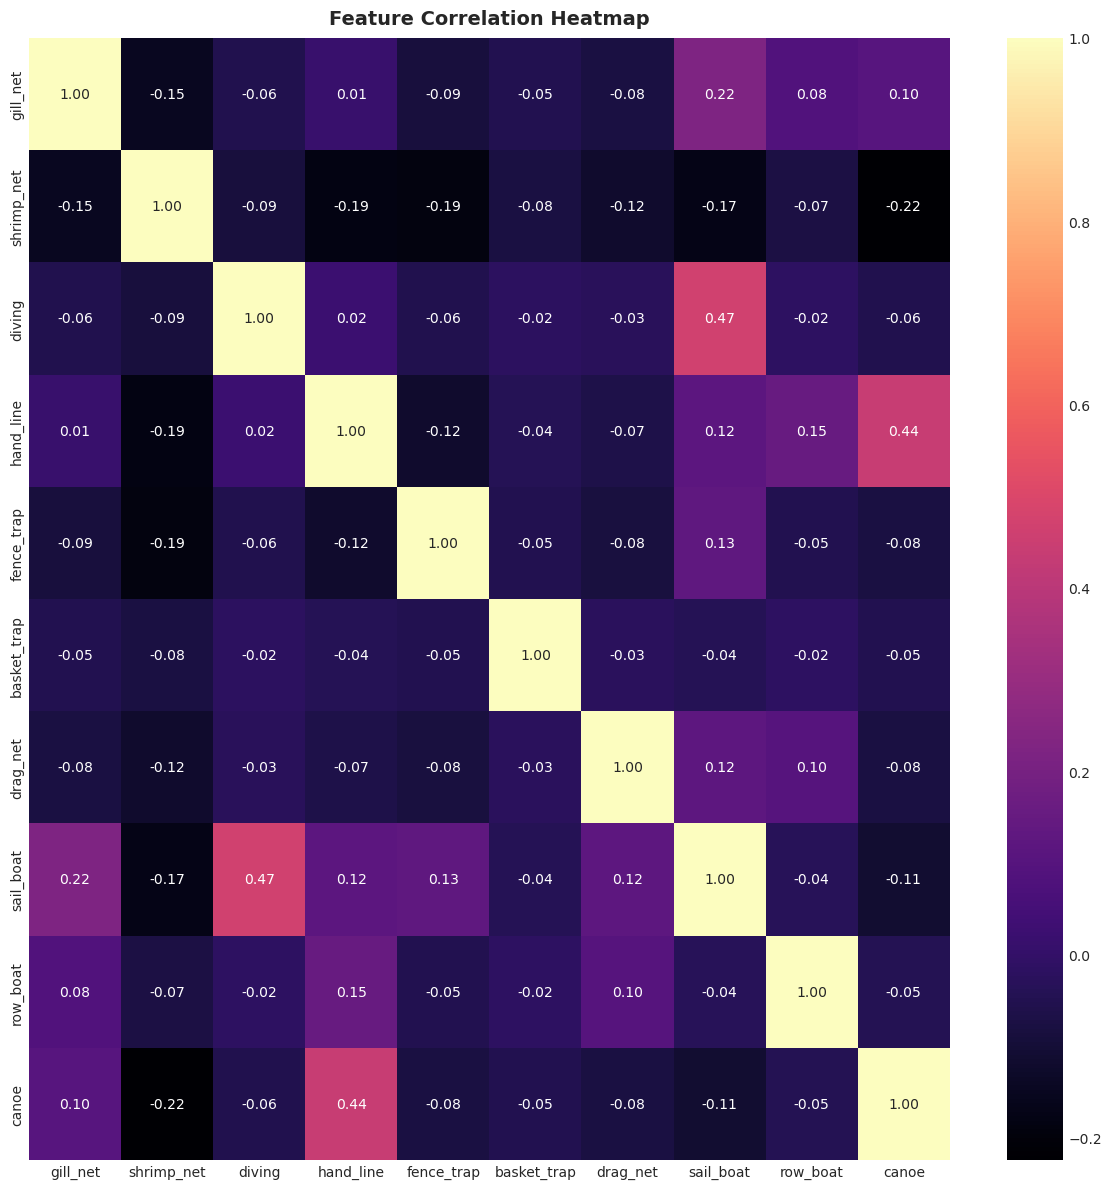

In [1804]:
# create covariance matrix
corr_matrix = np.corrcoef(X_norm.T)

# create heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, cmap='magma', annot=True, fmt='.2f',
            xticklabels=df[num_cols].columns, yticklabels=df[num_cols].columns)

# set plot title
plt.title('Feature Correlation Heatmap')

# show plot
plt.show()

### Scree Test

In [1805]:
# calculate eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

# sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]

# convert to dataframes
eigenvalues_df = pd.DataFrame({'Eigenvalue': eigenvalues}, index=[f"C{i+1}" for i in range(10)])
eigenvalues_df['Proportion'] = eigenvalues_df['Eigenvalue'] / eigenvalues_df['Eigenvalue'].sum()
eigenvalues_df['Cumulative Proportion'] = eigenvalues_df['Proportion'].cumsum()

# display dataframes
print("Eigenvalues:")
display(eigenvalues_df.style.format({'Eigenvalue': '{:.4f}', 'Proportion': '{:.4f}', 'Cumulative Proportion': '{:.4f}'}))

Eigenvalues:


,Eigenvalue,Proportion,Cumulative Proportion
C1,1.7058,0.1706,0.1706
C2,1.5362,0.1536,0.3242
C3,1.1654,0.1165,0.4407
C4,1.1455,0.1146,0.5553
C5,1.0601,0.1060,0.6613
C6,1.0217,0.1022,0.7635
C7,0.9222,0.0922,0.8557
C8,0.6396,0.0640,0.9196
C9,0.5009,0.0501,0.9697
C10,0.3026,0.0303,1.0000


6 comonents have eigenvalues over 1. These account for >80% of the variance

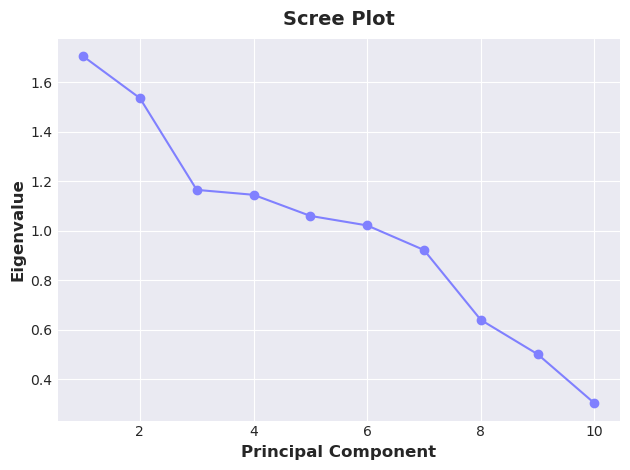

In [1806]:
# plot scree plot
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', color='#8080ff')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

Scree test suggests 7 components

[0.17058106 0.15362417 0.11653818 0.11455053 0.1060109  0.10216608
 0.09221846 0.06395916 0.05008995 0.0302615 ]


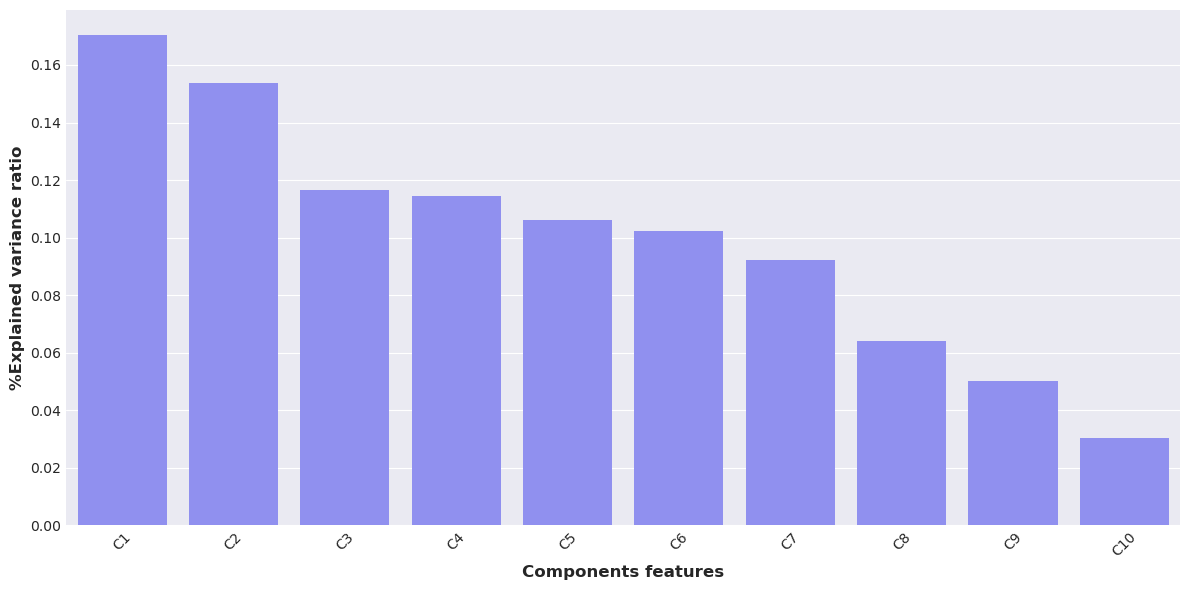

In [1807]:
evr = pca.explained_variance_ratio_
print(evr)

# plot the EVR using matplotlib pyplot    
plt.figure(figsize=(12,6))
sns.barplot(x=[f"C{i+1}" for i in range(10)], y=evr, color='#8080ff')
plt.xlabel("Components features")
plt.ylabel("%Explained variance ratio")
plt.xticks(rotation = 45)
plt.show()

### Varimax Rotation

In [1808]:
loadings = pd.DataFrame(pca.components_.T[:,:7], index=np.array(features), columns=names[:7])
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
gill_net,0.292388,-0.005825,0.071890,0.016413,-0.736413,0.430360,-0.202394
shrimp_net,-0.473636,-0.008367,0.118490,0.509059,-0.115975,-0.124198,0.112040
diving,0.305206,0.477041,-0.003578,0.412145,0.261569,-0.044166,0.172369
hand_line,0.480997,-0.372125,0.032018,0.156229,0.213389,-0.165107,0.193265
fence_trap,0.006427,0.222832,-0.543668,-0.553765,-0.079362,-0.227389,0.262987
basket_trap,-0.060690,-0.004540,-0.006139,-0.140710,0.480912,0.810795,0.101454
drag_net,0.044897,0.165289,0.565458,-0.373217,0.231530,-0.229935,-0.525116
sail_boat,0.435314,0.536977,-0.003374,0.118663,-0.054735,0.014089,-0.038696
row_boat,0.138226,-0.102281,0.568800,-0.246412,-0.155440,-0.029422,0.690132
canoe,0.389005,-0.507987,-0.202123,0.075977,0.109334,-0.084408,-0.215499


In [1809]:
# fit factor analyzer with principal components and varimax rotation
fa = FactorAnalyzer(rotation="varimax", n_factors=3, method='principal')

X = df[features]

# normalizing features
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)
fa.fit(X_norm)

# get the rotated factor pattern
loadings2 = pd.DataFrame(fa.loadings_, index=X_norm.columns, columns=[f"Factor{i+1}" for i in range(3)])
#rotated_factor_pattern = loadings2[abs(loadings2) >= 0.4].dropna(how='all')

# display the results
loadings2

,Factor1,Factor2,Factor3
gill_net,0.306976,0.212693,0.111505
shrimp_net,-0.516172,-0.356902,0.072957
diving,-0.005244,0.712773,-0.020952
hand_line,0.768734,-0.021959,0.130945
fence_trap,-0.075764,0.218611,-0.606035
basket_trap,-0.060887,-0.049795,-0.013106
drag_net,-0.142334,0.215803,0.592622
sail_boat,0.092082,0.870401,-0.012256
row_boat,0.143140,0.012236,0.636446
canoe,0.796131,-0.234514,-0.115531


In [1810]:
rotated_factor_pattern = loadings2[abs(loadings2) >= 0.395].dropna(how='all')
rotated_factor_pattern

,Factor1,Factor2,Factor3
shrimp_net,-0.516172,NaN,NaN
diving,NaN,0.712773,NaN
hand_line,0.768734,NaN,NaN
fence_trap,NaN,NaN,-0.606035
drag_net,NaN,NaN,0.592622
sail_boat,NaN,0.870401,NaN
row_boat,NaN,NaN,0.636446
canoe,0.796131,NaN,NaN


In [1811]:
to_remove = loadings2[(abs(loadings2['Factor1'])<0.395) & 
                        (abs(loadings2['Factor2'])<0.395) & 
                        (abs(loadings2['Factor3'])<0.395) #& 
                        #(abs(loadings2['Factor4'])<0.395)& 
                        #(abs(loadings2['Factor5'])<0.395)#& 
                        #(abs(loadings2['Factor6'])<0.395)#& 
                        #(abs(loadings2['Factor7'])<0.395)
                        ]
to_remove_list=to_remove.index.tolist()
to_remove_list

['gill_net', 'basket_trap']

## Second PCA
### Remove columns 

In [1812]:
# define features for factor analysis - remove the components with loadings <0.04 (see above)
features = num_cols
col_remove =['gill_net', 'basket_trap']
features = [value for value in features if value not in col_remove]
print(features) 

['shrimp_net', 'diving', 'hand_line', 'fence_trap', 'drag_net', 'sail_boat', 'row_boat', 'canoe']


### Standardize data

In [1813]:

# normalizing features
X = df.loc[:, features].values
X_norm = StandardScaler().fit_transform(X) # normalizing the features

# principal component analysis on features
pca = PCA()

X_pca = pca.fit_transform(X_norm)

# converting to dataframe
names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pcadf = pd.DataFrame(X_pca, columns=names)


print(X_pcadf.head())
print("-----------------------------------")
print("Shape of PCA DataFrame:", X_pcadf.shape)

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.242298 -0.017624  0.005059 -0.128700 -0.113060  0.702886  0.571244   
1 -0.242298 -0.017624  0.005059 -0.128700 -0.113060  0.702886  0.571244   
2 -0.242298 -0.017624  0.005059 -0.128700 -0.113060  0.702886  0.571244   
3 -0.242298 -0.017624  0.005059 -0.128700 -0.113060  0.702886  0.571244   
4 -1.171811 -0.026310  0.210250  0.792387  0.140527 -0.405518 -0.174924   

        PC8  
0  0.016696  
1  0.016696  
2  0.016696  
3  0.016696  
4 -0.021084  
-----------------------------------
Shape of PCA DataFrame: (96, 8)


### Covariance Matrix

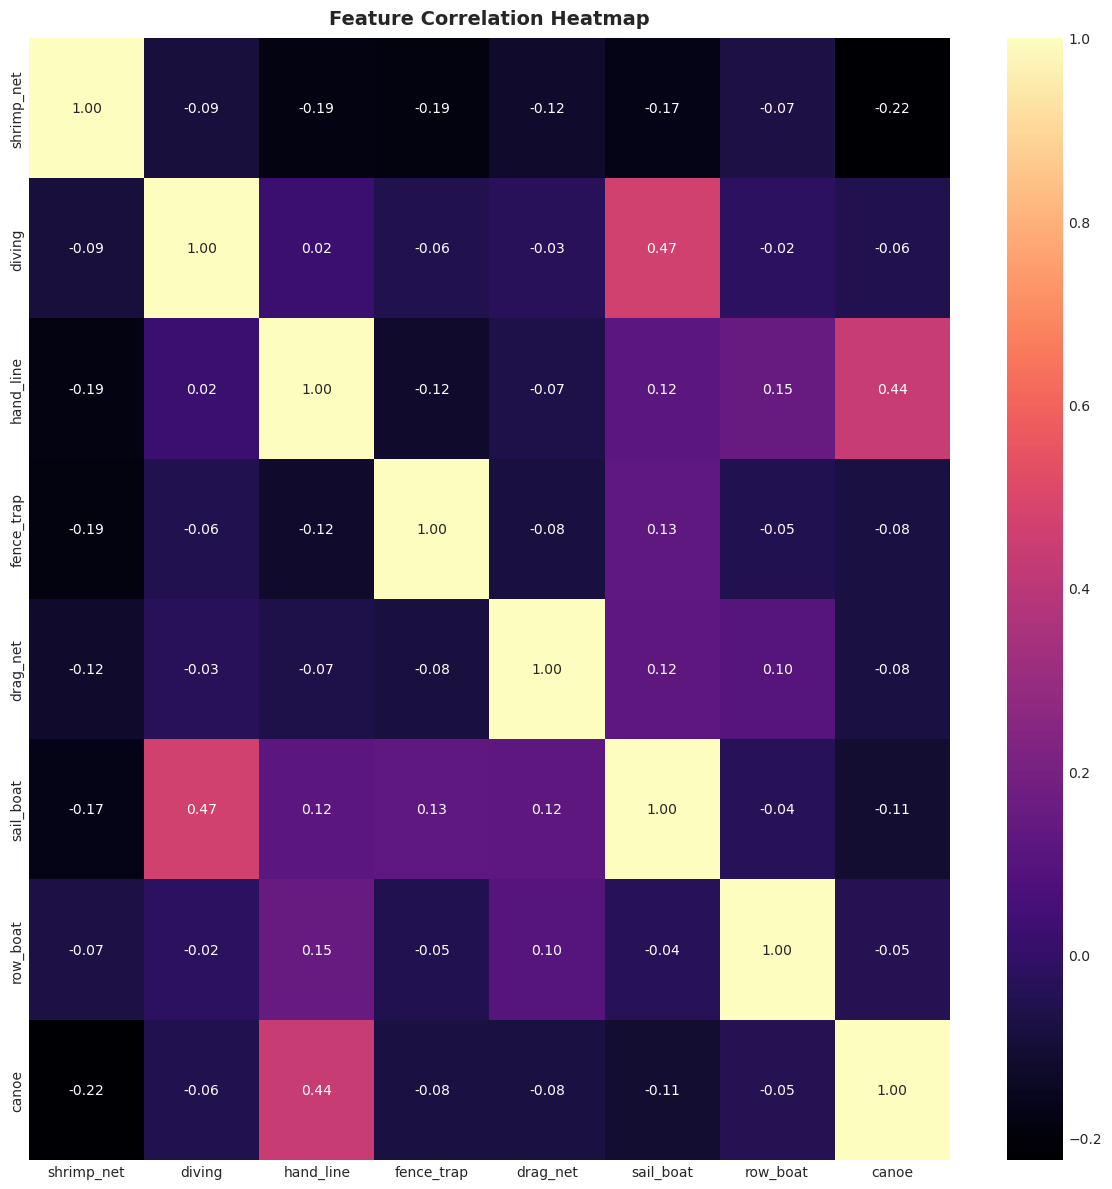

In [1814]:
# create covariance matrix
corr_matrix = np.corrcoef(X_norm.T)

# create heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, cmap='magma', annot=True, fmt='.2f',
            xticklabels=df[features].columns, yticklabels=df[features].columns)

# set plot title
plt.title('Feature Correlation Heatmap')

# show plot
plt.show()

### Scree Test

In [1815]:
# calculate eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

# sort the eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]

# convert to dataframes
eigenvalues_df = pd.DataFrame({'Eigenvalue': eigenvalues}, index=[f"C{i+1}" for i in range(8)])
eigenvalues_df['Proportion'] = eigenvalues_df['Eigenvalue'] / eigenvalues_df['Eigenvalue'].sum()
eigenvalues_df['Cumulative Proportion'] = eigenvalues_df['Proportion'].cumsum()

# display dataframes
print("Eigenvalues:")
display(eigenvalues_df.style.format({'Eigenvalue': '{:.4f}', 'Proportion': '{:.4f}', 'Cumulative Proportion': '{:.4f}'}))

Eigenvalues:


,Eigenvalue,Proportion,Cumulative Proportion
C1,1.6432,0.2054,0.2054
C2,1.5362,0.1920,0.3974
C3,1.1646,0.1456,0.5430
C4,1.1431,0.1429,0.6859
C5,0.9309,0.1164,0.8023
C6,0.6619,0.0827,0.8850
C7,0.5268,0.0659,0.9508
C8,0.3932,0.0492,1.0000


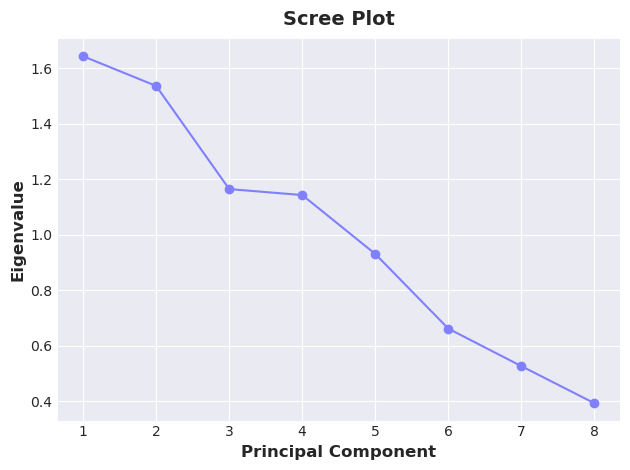

In [1816]:
# plot scree plot
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', color='#8080ff')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

Scree test suggests 6 components

### Varimax rotation

In [1817]:
# fit factor analyzer with principal components and varimax rotation
fa = FactorAnalyzer(rotation="varimax", n_factors=6, method='principal')

X = df[features]

# normalizing features
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)
fa.fit(X_norm)

# get the rotated factor pattern
loadings2 = pd.DataFrame(fa.loadings_, index=X_norm.columns, columns=[f"Factor{i+1}" for i in range(6)])


# display the results
loadings2

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
shrimp_net,-0.109114,-0.139377,-0.158422,-0.109159,-0.067411,0.919567
diving,0.848252,-0.102661,-0.233307,-0.180858,-0.005196,-0.159921
hand_line,0.125078,0.902237,-0.007696,-0.004791,0.186713,0.031897
fence_trap,0.006412,-0.100980,0.939382,-0.087087,-0.035080,-0.143310
drag_net,0.018750,-0.072967,-0.082577,0.963543,0.043888,-0.094990
sail_boat,0.849323,0.108359,0.253127,0.217389,-0.033648,0.034598
row_boat,-0.034715,0.044625,-0.034961,0.041623,0.978183,-0.053097
canoe,-0.178879,0.739324,-0.147633,-0.109080,-0.197300,-0.339575


### Factor Anaylsis

In [1818]:
rotated_factor_pattern = loadings2[abs(loadings2) > 0.395].dropna(how='all')
rotated_factor_pattern

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
shrimp_net,NaN,NaN,NaN,NaN,NaN,0.919567
diving,0.848252,NaN,NaN,NaN,NaN,NaN
hand_line,NaN,0.902237,NaN,NaN,NaN,NaN
fence_trap,NaN,NaN,0.939382,NaN,NaN,NaN
drag_net,NaN,NaN,NaN,0.963543,NaN,NaN
sail_boat,0.849323,NaN,NaN,NaN,NaN,NaN
row_boat,NaN,NaN,NaN,NaN,0.978183,NaN
canoe,NaN,0.739324,NaN,NaN,NaN,NaN


In [1819]:
to_remove = loadings2[(abs(loadings2['Factor1'])<0.395) & 
                        (abs(loadings2['Factor2'])<0.395) & 
                        (abs(loadings2['Factor3'])<0.395)& 
                        (abs(loadings2['Factor4'])<0.395)& 
                        (abs(loadings2['Factor5'])<0.395)& 
                        (abs(loadings2['Factor6'])<0.395)]
to_remove_list=to_remove.index.tolist()
to_remove_list

[]

### Extract Factor Scores

In [1820]:
# Normalized variables
X = df.reset_index().set_index(["id","pract_cat"])
X_norm_vals = StandardScaler().fit_transform(X.values)
X_norm = pd.DataFrame(X_norm_vals, index=X.index, columns=X.columns)
X_norm

,,index,gill_net,shrimp_net,diving,hand_line,fence_trap,basket_trap,drag_net,owner_boat,sail_boat,row_boat,canoe
id,pract_cat,,,,,,,,,,,,
05032023JOSC01,glean,-1.714102,-0.382451,-0.593391,-0.145865,-0.313131,-0.388071,-0.130189,-0.208514,-0.464991,-0.29173,-0.124727,-0.377964
05032023JOSC02,glean,-1.678015,-0.382451,-0.593391,-0.145865,-0.313131,-0.388071,-0.130189,-0.208514,-0.464991,-0.29173,-0.124727,-0.377964
05032023JOSC03,fish,-1.641929,0.928809,-0.593391,-0.145865,-0.313131,-0.388071,-0.130189,-0.208514,-0.464991,-0.29173,-0.124727,-0.377964
05032023JOSC04,glean,-1.605843,-0.382451,-0.593391,-0.145865,-0.313131,-0.388071,-0.130189,-0.208514,-0.464991,-0.29173,-0.124727,-0.377964
05032023JOSC05,shrimp_net,-1.569756,-0.382451,1.305460,-0.145865,-0.313131,-0.388071,-0.130189,-0.208514,-0.464991,-0.29173,-0.124727,-0.377964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19022023ILHC03,shrimp_net,1.569756,-0.382451,1.305460,-0.145865,-0.313131,-0.388071,-0.130189,-0.208514,-0.464991,-0.29173,-0.124727,-0.377964
19022023ILHC04,shrimp_net,1.605843,-0.382451,1.305460,-0.145865,-0.313131,-0.388071,-0.130189,-0.208514,-0.464991,-0.29173,-0.124727,-0.377964
19022023ILHc06,shrimp_net,1.641929,-0.382451,1.305460,-0.145865,-0.313131,-0.388071,-0.130189,-0.208514,-0.464991,-0.29173,-0.124727,-0.377964


In [1821]:
# function to calculate factor score
def calculate_fact_score(factor, row):
    fact_score = 0
    for componenet in features:
        comp_score = loadings2[factor][componenet]*row[componenet]
        fact_score = fact_score + comp_score
    return fact_score

# calculate factor scores for each factor
for factor in loadings2.columns:
    col = factor + "_score"
    X_norm[col]= X_norm.apply(lambda row: calculate_fact_score(factor, row), axis=1 )

df = X_norm[['Factor1_score', 'Factor2_score', 'Factor3_score','Factor4_score','Factor5_score','Factor6_score']]
df

,,Factor1_score,Factor2_score,Factor3_score,Factor4_score,Factor5_score,Factor6_score
id,pract_cat,,,,,,
05032023JOSC01,glean,-0.280380,-0.447052,-0.230565,-0.101843,-0.050862,-0.332026
05032023JOSC02,glean,-0.280380,-0.447052,-0.230565,-0.101843,-0.050862,-0.332026
05032023JOSC03,fish,-0.280380,-0.447052,-0.230565,-0.101843,-0.050862,-0.332026
05032023JOSC04,glean,-0.280380,-0.447052,-0.230565,-0.101843,-0.050862,-0.332026
05032023JOSC05,shrimp_net,-0.487571,-0.711708,-0.531385,-0.309120,-0.178866,1.414094
...,...,...,...,...,...,...,...
19022023ILHC03,shrimp_net,-0.487571,-0.711708,-0.531385,-0.309120,-0.178866,1.414094
19022023ILHC04,shrimp_net,-0.487571,-0.711708,-0.531385,-0.309120,-0.178866,1.414094
19022023ILHc06,shrimp_net,-0.487571,-0.711708,-0.531385,-0.309120,-0.178866,1.414094


In [1822]:
# Normalize factor scores
fact_norm_vals = StandardScaler().fit_transform(df.values)
fact_norm = pd.DataFrame(fact_norm_vals, index=df.index, columns=df.columns)



### Calculate final fishing asset scores

In [1823]:
print(evr)

[0.17058106 0.15362417 0.11653818 0.11455053 0.1060109  0.10216608
 0.09221846 0.06395916 0.05008995 0.0302615 ]


In [1824]:
def msl_score(factor1,factor2,factor3,factor4,factor5,factor6):
    score = factor1*evr[0]+ factor2*evr[1]+factor3*evr[2]+factor4*evr[3]+factor5*evr[4]+factor6*evr[5]
    return score

fact_norm["fish_asset_score"]= fact_norm.apply(lambda row: msl_score(row['Factor1_score'], row['Factor2_score'], row['Factor3_score'], row['Factor4_score'], row['Factor5_score'], row['Factor6_score']), axis=1 )
fact_norm

,,Factor1_score,Factor2_score,Factor3_score,Factor4_score,Factor5_score,Factor6_score,fish_asset_score
id,pract_cat,,,,,,,
05032023JOSC01,glean,-0.185407,-0.305350,-0.213148,-0.096110,-0.048480,-0.302628,-0.150443
05032023JOSC02,glean,-0.185407,-0.305350,-0.213148,-0.096110,-0.048480,-0.302628,-0.150443
05032023JOSC03,fish,-0.185407,-0.305350,-0.213148,-0.096110,-0.048480,-0.302628,-0.150443
05032023JOSC04,glean,-0.185407,-0.305350,-0.213148,-0.096110,-0.048480,-0.302628,-0.150443
05032023JOSC05,shrimp_net,-0.322418,-0.486118,-0.491244,-0.291717,-0.170491,1.288888,-0.106736
...,...,...,...,...,...,...,...,...
19022023ILHC03,shrimp_net,-0.322418,-0.486118,-0.491244,-0.291717,-0.170491,1.288888,-0.106736
19022023ILHC04,shrimp_net,-0.322418,-0.486118,-0.491244,-0.291717,-0.170491,1.288888,-0.106736
19022023ILHc06,shrimp_net,-0.322418,-0.486118,-0.491244,-0.291717,-0.170491,1.288888,-0.106736


In [1825]:
#Export CSV
fact_norm.to_csv("../fishing_asset_scores.csv")

In [1826]:
# group by practice category
fact_norm.groupby('pract_cat').describe()

Factor1_score                                                    \
                   count      mean       std       min       25%       50%   
pract_cat                                                                    
fish                48.0  0.262476  1.376488 -0.543077 -0.307994 -0.176115   
glean               24.0 -0.185407  0.000000 -0.185407 -0.185407 -0.185407   
shrimp_net          24.0 -0.339544  0.046286 -0.459428 -0.322418 -0.322418   

                               Factor2_score            ... Factor6_score  \
                 75%       max         count      mean  ...           75%   
pract_cat                                               ...                 
fish       -0.007813  7.753148          48.0  0.407032  ...     -0.302628   
glean      -0.185407 -0.185407          24.0 -0.305350  ...     -0.302628   
shrimp_net -0.322418 -0.322418          24.0 -0.508714  ...      1.288888   

                     fish_asset_score                                    \
                 max            count      mean           std       min   
pract_cat                                                                 
fish        1.288888             48.0  0.125858  3.395186e-01 -0.216527   
glean      -0.302628             24.0 -0.150443  2.835254e-17 -0.150443   
shrimp_net  2.880403             24.0 -0.101273  1.476563e-02 -0.106736   

                                                    
                 25%       50%       75%       max  
pract_cat                                           
fish       -0.117663  0.007656  0.231788  1.251219  
glean      -0.150443 -0.150443 -0.150443 -0.150443  
shrimp_net -0.106736 -0.106736 -0.106736 -0.063029  

[3 rows x 56 columns]